### Installation and Imports

In [1]:
#! pip install fredapi
#! pip install pandas_ta
#! pip install fastparquet
#! pip install pyarrow

In [2]:
from fredapi import Fred
import pandas as pd
import numpy as np
import pandas_ta as ta
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",100)

2024-12-12 10:54:18.380837: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Fetching for Commodities

In [3]:

# Initialize Fred with your API key
fred = Fred(api_key='db61e0d65c4d2a1053221aec21822d4e')  # Replace with your actual API key securely

# Define date range
start_date = '2002-01-01'
end_date = '2024-11-28'

# Define the indicators and their series IDs
indicators = {
    'Effective Federal Funds Rate': 'FEDFUNDS',
    '10-Year Treasury Rate': 'DGS10',
    'Consumer Price Index': 'CPIAUCSL',
    'Producer Price Index': 'PPIACO',
    'Unemployment Rate': 'UNRATE',
    'Nonfarm Payroll Employment': 'PAYEMS',
    'Real GDP': 'GDPC1',
    'Housing Starts': 'HOUST',
    'Industrial Production Index': 'INDPRO',
    'M2 Money Stock': 'M2SL',
    'Crude Oil Prices': 'DCOILWTICO',
    'Retail Sales': 'RSXFS',  # Corrected series ID for Retail Sales
    'Total Business Inventories': 'BUSINV'
}

# Fetch the data with date range
economic_data = pd.DataFrame()

for name, series_id in indicators.items():
    try:
        data = fred.get_series(
            series_id,
            observation_start=start_date,
            observation_end=end_date
        )
        if data is not None and not data.empty:
            economic_data[name] = data
            print(f"Successfully fetched data for {name}")
    except Exception as e:
        print(f"Error fetching {name}: {e}")

# Convert index to datetime if not already
economic_data.index = pd.to_datetime(economic_data.index)

Successfully fetched data for Effective Federal Funds Rate
Successfully fetched data for 10-Year Treasury Rate
Successfully fetched data for Consumer Price Index
Successfully fetched data for Producer Price Index
Successfully fetched data for Unemployment Rate
Successfully fetched data for Nonfarm Payroll Employment
Successfully fetched data for Real GDP
Successfully fetched data for Housing Starts
Successfully fetched data for Industrial Production Index
Successfully fetched data for M2 Money Stock
Successfully fetched data for Crude Oil Prices
Successfully fetched data for Retail Sales
Successfully fetched data for Total Business Inventories


In [4]:
economic_data.head()

,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories
2002-01-01,1.73,NaN,177.7,128.5,5.7,130853.0,14372.785,1698.0,88.4634,5461.1,NaN,256307.0,1117388.0
2002-02-01,1.74,5.02,178.0,128.4,5.7,130732.0,NaN,1829.0,88.4578,5490.4,20.40,257670.0,1111859.0
2002-03-01,1.73,4.98,178.5,129.8,5.7,130720.0,NaN,1642.0,89.1265,5502.2,22.37,257059.0,1108193.0
2002-04-01,1.75,5.44,179.3,130.8,5.9,130616.0,14460.848,1592.0,89.5507,5502.3,26.82,261333.0,1106806.0
2002-05-01,1.75,5.08,179.5,130.8,5.8,130632.0,NaN,1764.0,89.9348,5528.5,26.58,257573.0,1110725.0


In [5]:
economic_data.shape

(275, 13)

In [6]:
economic_data.to_csv('economic_data.csv')

In [7]:
economic_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 275 entries, 2002-01-01 to 2024-11-01
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Effective Federal Funds Rate  275 non-null    float64
 1   10-Year Treasury Rate         179 non-null    float64
 2   Consumer Price Index          275 non-null    float64
 3   Producer Price Index          275 non-null    float64
 4   Unemployment Rate             275 non-null    float64
 5   Nonfarm Payroll Employment    275 non-null    float64
 6   Real GDP                      91 non-null     float64
 7   Housing Starts                274 non-null    float64
 8   Industrial Production Index   274 non-null    float64
 9   M2 Money Stock                274 non-null    float64
 10  Crude Oil Prices              179 non-null    float64
 11  Retail Sales                  274 non-null    float64
 12  Total Business Inventories    273 non-null   

In [8]:

# Ensure the DataFrame is sorted by date
economic_data.sort_index(inplace=True)

# Fill missing values
def fill_missing_values(df):
    df_filled = df.copy()

    # Ensure index is DatetimeIndex
    if not isinstance(df_filled.index, pd.DatetimeIndex):
        df_filled.index = pd.to_datetime(df_filled.index)
    df_filled.sort_index(inplace=True)

    # Create Month and Year columns once
    df_filled['Month'] = df_filled.index.month
    df_filled['Year'] = df_filled.index.year

    # Process each column individually
    for column in df.columns:
        col_data = df_filled[['Year', 'Month', column]].copy()

        # Calculate monthly means
        monthly_means = col_data.groupby(['Year', 'Month'])[column].mean().rename('Monthly_Mean').reset_index()

        # Merge monthly means back into col_data
        col_data = col_data.merge(monthly_means, on=['Year', 'Month'], how='left')

        # Fill missing values with Monthly Mean
        null_mask = col_data[column].isnull()
        col_data.loc[null_mask, column] = col_data.loc[null_mask, 'Monthly_Mean']

        # Calculate yearly means
        yearly_means = col_data.groupby('Year')[column].mean().rename('Yearly_Mean').reset_index()

        # Merge yearly means into col_data
        col_data = col_data.merge(yearly_means, on='Year', how='left')

        # Fill remaining missing values with Yearly Mean
        still_null_mask = col_data[column].isnull()
        col_data.loc[still_null_mask, column] = col_data.loc[still_null_mask, 'Yearly_Mean']

        # Update the filled values back into df_filled
        df_filled.loc[:, column] = col_data[column].values

    # Drop the auxiliary columns
    df_filled.drop(['Month', 'Year'], axis=1, inplace=True)

    return df_filled


# Apply the function to fill missing values
economic_data_filled = fill_missing_values(economic_data)
if not isinstance(economic_data_filled.index, pd.DatetimeIndex):
    economic_data_filled.index = pd.to_datetime(economic_data_filled.index)
# Ensure the DataFrame is sorted by date
economic_data_filled.sort_index(inplace=True)
print(economic_data_filled.index)
# Preview the filled data
print(economic_data_filled.head())


DatetimeIndex(['2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01', '2002-10-01',
               ...
               '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01'],
              dtype='datetime64[ns]', length=275, freq=None)
            Effective Federal Funds Rate  10-Year Treasury Rate  \
2002-01-01                          1.73                4.69625   
2002-02-01                          1.74                5.02000   
2002-03-01                          1.73                4.98000   
2002-04-01                          1.75                5.44000   
2002-05-01                          1.75                5.08000   

            Consumer Price Index  Producer Price Index  Unemployment Rate  \
2002-01-01                 177.7                 128.5               

In [9]:
print(economic_data_filled.isna().sum())

Effective Federal Funds Rate    0
10-Year Treasury Rate           0
Consumer Price Index            0
Producer Price Index            0
Unemployment Rate               0
Nonfarm Payroll Employment      0
Real GDP                        0
Housing Starts                  0
Industrial Production Index     0
M2 Money Stock                  0
Crude Oil Prices                0
Retail Sales                    0
Total Business Inventories      0
dtype: int64


In [10]:
economic_data_filled

,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories
2002-01-01,1.73,4.69625,177.700,128.500,5.7,130853.0,14372.785000,1698.0,88.46340,5461.10,25.9025,256307.0,1.117388e+06
2002-02-01,1.74,5.02000,178.000,128.400,5.7,130732.0,14472.711500,1829.0,88.45780,5490.40,20.4000,257670.0,1.111859e+06
2002-03-01,1.73,4.98000,178.500,129.800,5.7,130720.0,14472.711500,1642.0,89.12650,5502.20,22.3700,257059.0,1.108193e+06
2002-04-01,1.75,5.44000,179.300,130.800,5.9,130616.0,14460.848000,1592.0,89.55070,5502.30,26.8200,261333.0,1.106806e+06
2002-05-01,1.75,5.08000,179.500,130.800,5.8,130632.0,14472.711500,1764.0,89.93480,5528.50,26.5800,257573.0,1.110725e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,5.33,4.48000,313.534,257.321,4.3,158692.0,23386.733000,1262.0,102.53810,21039.40,84.7000,615960.0,2.574892e+06
2024-08-01,5.33,3.99000,314.121,255.430,4.2,158770.0,23221.394667,1379.0,103.04490,21141.30,77.7400,614535.0,2.583708e+06
2024-09-01,5.13,4.20000,314.686,252.690,4.1,159025.0,23221.394667,1353.0,102.54970,21222.70,77.8950,619411.0,2.587145e+06
2024-10-01,4.83,3.74000,315.454,253.162,4.1,159061.0,23221.394667,1311.0,102.28050,21311.20,70.4100,621590.0,2.558768e+06


In [11]:
economic_data_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 275 entries, 2002-01-01 to 2024-11-01
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Effective Federal Funds Rate  275 non-null    float64
 1   10-Year Treasury Rate         275 non-null    float64
 2   Consumer Price Index          275 non-null    float64
 3   Producer Price Index          275 non-null    float64
 4   Unemployment Rate             275 non-null    float64
 5   Nonfarm Payroll Employment    275 non-null    float64
 6   Real GDP                      275 non-null    float64
 7   Housing Starts                275 non-null    float64
 8   Industrial Production Index   275 non-null    float64
 9   M2 Money Stock                275 non-null    float64
 10  Crude Oil Prices              275 non-null    float64
 11  Retail Sales                  275 non-null    float64
 12  Total Business Inventories    275 non-null   

### Stock Data

In [12]:
stock_data = pd.read_parquet('sp500_50stocks_data.parquet')
# Convert index to DatetimeIndex if not already
if not isinstance(stock_data.index, pd.DatetimeIndex):
    stock_data.index = pd.to_datetime(stock_data.index)

# Sort by date
stock_data.sort_index(inplace=True)
stock_data

Ticker             AMD                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2003-01-02    6.560000    7.110000    6.470000    7.010000    7.010000   
2003-01-03    7.010000    7.190000    6.860000    6.940000    6.940000   
2003-01-06    7.050000    7.230000    7.000000    7.160000    7.160000   
2003-01-07    7.250000    7.480000    7.100000    7.170000    7.170000   
2003-01-08    7.060000    7.100000    6.630000    6.690000    6.690000   
...                ...         ...         ...         ...         ...   
2024-11-20  138.960007  140.770004  135.479996  137.600006  137.600006   
2024-11-21  138.869995  140.279999  134.929993  137.490005  137.490005   
2024-11-22  137.350006  139.130005  137.039993  138.350006  138.350006   
2024-11-25  140.490005  142.350006  139.050003  141.130005  141.130005   
2024-11-26  142.550003  142.800003  136.619995  137.720001  137.720001   

Ticker                      TSLA                                      \
Price         Volume        Open        High         Low       Close   
Date                                                                   
2003-01-02  17474800         NaN         NaN         NaN         NaN   
2003-01-03   6235700         NaN         NaN         NaN         NaN   
2003-01-06   6833200         NaN         NaN         NaN         NaN   
2003-01-07   9785100         NaN         NaN         NaN         NaN   
2003-01-08  13952300         NaN         NaN         NaN         NaN   
...              ...         ...         ...         ...         ...   
2024-11-20  28843100  345.000000  346.600006  334.299988  342.029999   
2024-11-21  29311400  343.809998  347.989990  335.279999  339.640015   
2024-11-22  21784700  341.089996  361.529999  337.700012  352.559998   
2024-11-25  30923100  360.140015  361.929993  338.200012  338.589996   
2024-11-26  32092400  341.000000  346.959991  335.660004  338.230011   

Ticker                                      PM                          \
Price        Adj Close      Volume        Open        High         Low   
Date                                                                     
2003-01-02         NaN         NaN         NaN         NaN         NaN   
2003-01-03         NaN         NaN         NaN         NaN         NaN   
2003-01-06         NaN         NaN         NaN         NaN         NaN   
2003-01-07         NaN         NaN         NaN         NaN         NaN   
2003-01-08         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2024-11-20  342.029999  66340700.0  129.619995  131.240005  128.800003   
2024-11-21  339.640015  58011700.0  130.500000  132.119995  130.410004   
2024-11-22  352.559998  89140700.0  131.740005  131.809998  129.830002   
2024-11-25  338.589996  95890900.0  130.669998  131.100006  129.160004   
2024-11-26  338.230011  62295900.0  130.729996  132.940002  130.529999   

Ticker                                                  V              \
Price            Close   Adj Close     Volume        Open        High   
Date                                                                    
2003-01-02         NaN         NaN        NaN         NaN         NaN   
2003-01-03         NaN         NaN        NaN         NaN         NaN   
2003-01-06         NaN         NaN        NaN         NaN         NaN   
2003-01-07         NaN         NaN        NaN         NaN         NaN   
2003-01-08         NaN         NaN        NaN         NaN         NaN   
...                ...         ...        ...         ...         ...   
2024-11-20  130.389999  130.389999  4172700.0  311.859985  312.290009   
2024-11-21  131.210007  131.210007  3605100.0  307.299988  310.920013   
2024-11-22  129.990005  129.990005  4108200.0  307.970001  311.589996   
2024-11-25  130.710007  130.710007  43641

In [13]:
print(f"Economic data date range: {economic_data_filled.index.min()} to {economic_data_filled.index.max()}")
print(f"Stock data date range: {stock_data.index.min()} to {stock_data.index.max()}")

Economic data date range: 2002-01-01 00:00:00 to 2024-11-01 00:00:00
Stock data date range: 2003-01-02 00:00:00 to 2024-11-26 00:00:00


In [14]:
stock_data.columns

MultiIndex([( 'AMD',      'Open'),
            ( 'AMD',      'High'),
            ( 'AMD',       'Low'),
            ( 'AMD',     'Close'),
            ( 'AMD', 'Adj Close'),
            ( 'AMD',    'Volume'),
            ('TSLA',      'Open'),
            ('TSLA',      'High'),
            ('TSLA',       'Low'),
            ('TSLA',     'Close'),
            ...
            (  'VZ',       'Low'),
            (  'VZ',     'Close'),
            (  'VZ', 'Adj Close'),
            (  'VZ',    'Volume'),
            ('AAPL',      'Open'),
            ('AAPL',      'High'),
            ('AAPL',       'Low'),
            ('AAPL',     'Close'),
            ('AAPL', 'Adj Close'),
            ('AAPL',    'Volume')],
           names=['Ticker', 'Price'], length=300)

In [15]:
isinstance(stock_data.columns, pd.MultiIndex)

True

In [16]:
stock_data.index

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2024-11-13', '2024-11-14', '2024-11-15', '2024-11-18',
               '2024-11-19', '2024-11-20', '2024-11-21', '2024-11-22',
               '2024-11-25', '2024-11-26'],
              dtype='datetime64[ns]', name='Date', length=5514, freq=None)

In [17]:
economic_data_filled.index

DatetimeIndex(['2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01', '2002-10-01',
               ...
               '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01'],
              dtype='datetime64[ns]', length=275, freq=None)

In [18]:
# Flatten MultiIndex columns in stock_data
stock_data.columns = ['_'.join(col).strip() for col in stock_data.columns.values]

In [19]:
economic_data_filled.index.name = 'Date'
stock_data.index.name = 'Date'

# Create a daily date range based on stock data index
daily_date_range = pd.date_range(
    start=stock_data.index.min(),
    end=stock_data.index.max(),
    freq='D'  # Daily frequency
)

# Reindex economic data to daily frequency using forward fill
economic_data_daily = economic_data_filled.reindex(daily_date_range, method='ffill')

# Ensure the index name is consistent
economic_data_daily.index.name = 'Date'

# Merge the DataFrames using the date index
combined_data = stock_data.join(economic_data_daily, how='left')

# Check for missing values after merging
missing_values = combined_data.isna().sum()
print("Missing values after merging:")
print(missing_values)


Missing values after merging:
AMD_Open                       0
AMD_High                       0
AMD_Low                        0
AMD_Close                      0
AMD_Adj Close                  0
                              ..
Industrial Production Index    0
M2 Money Stock                 0
Crude Oil Prices               0
Retail Sales                   0
Total Business Inventories     0
Length: 313, dtype: int64


In [20]:
# Optionally, forward fill remaining missing values
combined_data.ffill(inplace=True)

In [21]:
# Inspect the head of the combined DataFrame
print(combined_data.head())

# Check the DataFrame info
combined_data.info()

            AMD_Open  AMD_High  AMD_Low  AMD_Close  AMD_Adj Close  AMD_Volume  \
Date                                                                            
2003-01-02      6.56      7.11     6.47       7.01           7.01    17474800   
2003-01-03      7.01      7.19     6.86       6.94           6.94     6235700   
2003-01-06      7.05      7.23     7.00       7.16           7.16     6833200   
2003-01-07      7.25      7.48     7.10       7.17           7.17     9785100   
2003-01-08      7.06      7.10     6.63       6.69           6.69    13952300   

            TSLA_Open  TSLA_High  TSLA_Low  TSLA_Close  TSLA_Adj Close  \
Date                                                                     
2003-01-02        NaN        NaN       NaN         NaN             NaN   
2003-01-03        NaN        NaN       NaN         NaN             NaN   
2003-01-06        NaN        NaN       NaN         NaN             NaN   
2003-01-07        NaN        NaN       NaN         NaN        

In [22]:
print(combined_data.isna().any().sum())

72


In [23]:
combined_data.shape, stock_data.shape

((5514, 313), (5514, 300))

In [24]:
combined_data.head()

,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Adj Close,AMD_Volume,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_Adj Close,TSLA_Volume,PM_Open,PM_High,PM_Low,PM_Close,PM_Adj Close,PM_Volume,V_Open,V_High,V_Low,V_Close,V_Adj Close,V_Volume,NFLX_Open,NFLX_High,NFLX_Low,NFLX_Close,NFLX_Adj Close,NFLX_Volume,ACN_Open,ACN_High,ACN_Low,ACN_Close,ACN_Adj Close,ACN_Volume,XOM_Open,XOM_High,XOM_Low,XOM_Close,XOM_Adj Close,XOM_Volume,UNH_Open,UNH_High,UNH_Low,UNH_Close,UNH_Adj Close,UNH_Volume,JNJ_Open,JNJ_High,JNJ_Low,JNJ_Close,JNJ_Adj Close,JNJ_Volume,PG_Open,PG_High,PG_Low,PG_Close,PG_Adj Close,PG_Volume,QCOM_Open,QCOM_High,QCOM_Low,QCOM_Close,QCOM_Adj Close,QCOM_Volume,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Adj Close,NVDA_Volume,TMUS_Open,TMUS_High,TMUS_Low,TMUS_Close,TMUS_Adj Close,TMUS_Volume,JPM_Open,JPM_High,JPM_Low,JPM_Close,JPM_Adj Close,JPM_Volume,META_Open,META_High,META_Low,META_Close,META_Adj Close,META_Volume,ABT_Open,ABT_High,ABT_Low,ABT_Close,ABT_Adj Close,ABT_Volume,ISRG_Open,ISRG_High,ISRG_Low,ISRG_Close,ISRG_Adj Close,ISRG_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Adj Close,MSFT_Volume,LIN_Open,LIN_High,LIN_Low,LIN_Close,LIN_Adj Close,LIN_Volume,ADBE_Open,ADBE_High,ADBE_Low,ADBE_Close,ADBE_Adj Close,ADBE_Volume,ORCL_Open,ORCL_High,ORCL_Low,ORCL_Close,ORCL_Adj Close,ORCL_Volume,PEP_Open,PEP_High,PEP_Low,PEP_Close,PEP_Adj Close,PEP_Volume,DHR_Open,DHR_High,DHR_Low,DHR_Close,DHR_Adj Close,DHR_Volume,ABBV_Open,ABBV_High,ABBV_Low,ABBV_Close,ABBV_Adj Close,ABBV_Volume,KO_Open,KO_High,KO_Low,KO_Close,KO_Adj Close,KO_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Adj Close,IBM_Volume,GOOG_Open,GOOG_High,GOOG_Low,GOOG_Close,GOOG_Adj Close,GOOG_Volume,NOW_Open,NOW_High,NOW_Low,NOW_Close,NOW_Adj Close,NOW_Volume,CRM_Open,CRM_High,CRM_Low,CRM_Close,CRM_Adj Close,CRM_Volume,CAT_Open,CAT_High,CAT_Low,CAT_Close,CAT_Adj Close,CAT_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Adj Close,AMZN_Volume,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Adj Close,GOOGL_Volume,BAC_Open,BAC_High,BAC_Low,BAC_Close,BAC_Adj Close,BAC_Volume,TMO_Open,TMO_High,TMO_Low,TMO_Close,TMO_Adj Close,TMO_Volume,MS_Open,MS_High,MS_Low,MS_Close,MS_Adj Close,MS_Volume,GE_Open,GE_High,GE_Low,GE_Close,GE_Adj Close,GE_Volume,WFC_Open,WFC_High,WFC_Low,WFC_Close,WFC_Adj Close,WFC_Volume,CSCO_Open,CSCO_High,CSCO_Low,CSCO_Close,CSCO_Adj Close,CSCO_Volume,MA_Open,MA_High,MA_Low,MA_Close,MA_Adj Close,MA_Volume,MCD_Open,MCD_High,MCD_Low,MCD_Close,MCD_Adj Close,MCD_Volume,LLY_Open,LLY_High,LLY_Low,LLY_Close,LLY_Adj Close,LLY_Volume,WMT_Open,WMT_High,WMT_Low,WMT_Close,WMT_Adj Close,WMT_Volume,COST_Open,COST_High,COST_Low,COST_Close,COST_Adj Close,COST_Volume,AVGO_Open,AVGO_High,AVGO_Low,AVGO_Close,AVGO_Adj Close,AVGO_Volume,AXP_Open,AXP_High,AXP_Low,AXP_Close,AXP_Adj Close,AXP_Volume,CVX_Open,CVX_High,CVX_Low,CVX_Close,CVX_Adj Close,CVX_Volume,MRK_Open,MRK_High,MRK_Low,MRK_Close,MRK_Adj Close,MRK_Volume,HD_Open,HD_High,HD_Low,HD_Close,HD_Adj Close,HD_Volume,VZ_Open,VZ_High,VZ_Low,VZ_Close,VZ_Adj Close,VZ_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-01-02,6.56,7.11,6.47,7.01,7.01,17474800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.846429,0.900000,0.810714,0.817857,0.817857,8397200,18.00,18.680000,17.85,18.610001,13.193541,684200,35.000000,35.549999,34.970001,35.470001,17.341360,12798800,20.877501,21.427500,20.700001,21.4275

###  Additional Feature Engineering


In [25]:
tickers = ["AAPL", "NVDA", "MSFT", "GOOG", "GOOGL", "AMZN", "META", "AVGO", "LLY", "TSLA",
                 "WMT", "JPM", "V", "XOM", "UNH", "ORCL", "MA", "HD", "PG", "COST", "JNJ",
                 "NFLX", "ABBV", "BAC", "KO", "CRM", "CVX", "MRK", "TMUS", "AMD", "PEP",
                 "ACN", "LIN", "TMO", "MCD", "CSCO", "ADBE", "WFC", "IBM", "GE", "ABT",
                 "DHR", "AXP", "MS", "CAT", "NOW", "QCOM", "PM", "ISRG", "VZ"]

print(len(combined_data.columns))

for ticker in tickers:
    close_col = f'{ticker}_Close'

    if close_col in combined_data.columns:
        # Calculate SMA (Simple Moving Average)
        combined_data[f'{ticker}_SMA_20'] = ta.sma(combined_data[close_col], length=20)

        # Calculate RSI (Relative Strength Index)
        combined_data[f'{ticker}_RSI_14'] = ta.rsi(combined_data[close_col], length=14)

        # Calculate MACD (Moving Average Convergence Divergence)
        macd = ta.macd(combined_data[close_col], fast=12, slow=26)
        macd_columns = [f'{ticker}_MACD', f'{ticker}_MACD_Hist', f'{ticker}_MACD_Signal']
        macd.columns = macd_columns
        combined_data = pd.concat([combined_data, macd], axis=1)

        # Calculate Bollinger Bands
        bbands = ta.bbands(combined_data[close_col], length=20)
        bbands_columns = [f'{ticker}_BB_Lower', f'{ticker}_BB_Middle', f'{ticker}_BB_Upper', f'{ticker}_BB_Bandwidth', f'{ticker}_BB_Percentage']
        bbands.columns = bbands_columns
        combined_data = pd.concat([combined_data, bbands], axis=1)

        # Calculate Momentum
        combined_data[f'{ticker}_MOM_10'] = ta.mom(combined_data[close_col], length=10)
    else:
        print(f'Column {close_col} not found in combined_data.')

print(len(combined_data.columns))
combined_data.head(1)

313
863


,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Adj Close,AMD_Volume,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_Adj Close,TSLA_Volume,PM_Open,PM_High,PM_Low,PM_Close,PM_Adj Close,PM_Volume,V_Open,V_High,V_Low,V_Close,V_Adj Close,V_Volume,NFLX_Open,NFLX_High,NFLX_Low,NFLX_Close,NFLX_Adj Close,NFLX_Volume,ACN_Open,ACN_High,ACN_Low,ACN_Close,ACN_Adj Close,ACN_Volume,XOM_Open,XOM_High,XOM_Low,XOM_Close,XOM_Adj Close,XOM_Volume,UNH_Open,UNH_High,UNH_Low,UNH_Close,UNH_Adj Close,UNH_Volume,JNJ_Open,JNJ_High,JNJ_Low,JNJ_Close,JNJ_Adj Close,JNJ_Volume,PG_Open,PG_High,PG_Low,PG_Close,PG_Adj Close,PG_Volume,QCOM_Open,QCOM_High,QCOM_Low,QCOM_Close,QCOM_Adj Close,QCOM_Volume,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Adj Close,NVDA_Volume,TMUS_Open,TMUS_High,TMUS_Low,TMUS_Close,TMUS_Adj Close,TMUS_Volume,JPM_Open,JPM_High,JPM_Low,JPM_Close,JPM_Adj Close,JPM_Volume,META_Open,META_High,META_Low,META_Close,META_Adj Close,META_Volume,ABT_Open,ABT_High,ABT_Low,ABT_Close,ABT_Adj Close,ABT_Volume,ISRG_Open,ISRG_High,ISRG_Low,ISRG_Close,ISRG_Adj Close,ISRG_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Adj Close,MSFT_Volume,LIN_Open,LIN_High,LIN_Low,LIN_Close,LIN_Adj Close,LIN_Volume,ADBE_Open,ADBE_High,ADBE_Low,ADBE_Close,ADBE_Adj Close,ADBE_Volume,ORCL_Open,ORCL_High,ORCL_Low,ORCL_Close,ORCL_Adj Close,ORCL_Volume,PEP_Open,PEP_High,PEP_Low,PEP_Close,PEP_Adj Close,PEP_Volume,DHR_Open,DHR_High,DHR_Low,DHR_Close,DHR_Adj Close,DHR_Volume,ABBV_Open,ABBV_High,ABBV_Low,ABBV_Close,ABBV_Adj Close,ABBV_Volume,KO_Open,KO_High,KO_Low,KO_Close,KO_Adj Close,KO_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Adj Close,IBM_Volume,GOOG_Open,GOOG_High,GOOG_Low,GOOG_Close,GOOG_Adj Close,GOOG_Volume,NOW_Open,NOW_High,NOW_Low,NOW_Close,NOW_Adj Close,NOW_Volume,CRM_Open,CRM_High,CRM_Low,CRM_Close,CRM_Adj Close,CRM_Volume,CAT_Open,CAT_High,CAT_Low,CAT_Close,CAT_Adj Close,CAT_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Adj Close,AMZN_Volume,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Adj Close,GOOGL_Volume,BAC_Open,BAC_High,BAC_Low,BAC_Close,BAC_Adj Close,BAC_Volume,TMO_Open,TMO_High,TMO_Low,TMO_Close,TMO_Adj Close,TMO_Volume,MS_Open,MS_High,MS_Low,MS_Close,MS_Adj Close,MS_Volume,GE_Open,GE_High,GE_Low,GE_Close,GE_Adj Close,GE_Volume,WFC_Open,WFC_High,WFC_Low,WFC_Close,WFC_Adj Close,WFC_Volume,CSCO_Open,CSCO_High,CSCO_Low,CSCO_Close,CSCO_Adj Close,CSCO_Volume,MA_Open,MA_High,MA_Low,MA_Close,MA_Adj Close,MA_Volume,MCD_Open,MCD_High,MCD_Low,MCD_Close,MCD_Adj Close,MCD_Volume,LLY_Open,LLY_High,LLY_Low,LLY_Close,LLY_Adj Close,LLY_Volume,WMT_Open,WMT_High,WMT_Low,WMT_Close,WMT_Adj Close,WMT_Volume,COST_Open,COST_High,COST_Low,COST_Close,COST_Adj Close,COST_Volume,AVGO_Open,AVGO_High,AVGO_Low,AVGO_Close,AVGO_Adj Close,AVGO_Volume,AXP_Open,AXP_High,AXP_Low,AXP_Close,AXP_Adj Close,AXP_Volume,CVX_Open,CVX_High,CVX_Low,CVX_Close,CVX_Adj Close,CVX_Volume,MRK_Open,MRK_High,MRK_Low,MRK_Close,MRK_Adj Close,MRK_Volume,HD_Open,HD_High,HD_Low,HD_Close,HD_Adj Close,HD_Volume,VZ_Open,VZ_High,VZ_Low,VZ_Close,VZ_Adj Close,VZ_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories,AAPL_SMA_20,AAPL_RSI_14,AAPL_MACD,AAPL_MACD_Hist,AAPL_MACD_Signal,AAPL_BB_Lower,AAPL_BB_Middle,AAPL_BB_Upper,AAPL_BB_Bandwidth,AAPL_BB_Percentage,AAPL_MOM_10,NVDA_SMA_20,NVDA_RSI_14,NVDA_MACD,NVDA_MACD_Hist,NVDA_MACD_Signal,NVDA_BB_Lower,NVDA_BB_Middle,NVDA_BB_Upper,NVDA_BB_Bandwidth,NVDA_BB_Percentage,NVDA_MOM_10,MSFT_SMA_20,MSFT_RSI_14,MSFT_MACD,MSFT_MACD_Hist,MSFT_MACD_Signal,MSFT_BB_Lower,MSFT_BB_Middle,MSFT_BB_Upper,MSFT_BB_Bandwidth,MSFT_BB_Percentage,MSFT_MOM_10,GOOG_SMA_20,GOOG_RSI_14,GOOG_MACD,GOOG_MACD_Hist,GOOG_MACD_Signal,GOOG_BB_Lower,GOOG_BB_Middle,GOOG_BB_Upper,GOOG_BB_Bandwidth,GOOG_BB_Percentage,GOOG_MOM_10,G

In [26]:
# Number of lags
n_lags = 5

# Initialize an empty dictionary to store lagged features
lagged_features = {}

# Create lag features for stock prices
for ticker in tickers:
    close_col = f'{ticker}_Close'

    if close_col in combined_data.columns:
        for lag in range(1, n_lags + 1):
            lag_col_name = f'{ticker}_Close_Lag_{lag}'
            lagged_features[lag_col_name] = combined_data[close_col].shift(lag)
    else:
        print(f'Column {close_col} not found in combined_data.')

# Create lag features for economic indicators
economic_indicators = economic_data_filled.columns.tolist()

for indicator in economic_indicators:
    if indicator in combined_data.columns:
        for lag in range(1, n_lags + 1):
            lag_col_name = f'{indicator}_Lag_{lag}'
            lagged_features[lag_col_name] = combined_data[indicator].shift(lag)
    else:
        print(f'Indicator {indicator} not found in combined_data.')

# Convert the lagged features dictionary to a DataFrame
lagged_features_df = pd.DataFrame(lagged_features, index=combined_data.index)

# Concatenate the lagged features DataFrame to the original DataFrame
combined_data = pd.concat([combined_data, lagged_features_df], axis=1)

# Optionally, defragment the DataFrame to improve performance
combined_data = combined_data.copy()

# Print the number of columns
print(f"Total number of columns: {len(combined_data.columns)}")


Total number of columns: 1178


In [27]:
combined_data.shape

(5514, 1178)

In [28]:
combined_data.dropna().head()

,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Adj Close,AMD_Volume,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_Adj Close,TSLA_Volume,PM_Open,PM_High,PM_Low,PM_Close,PM_Adj Close,PM_Volume,V_Open,V_High,V_Low,V_Close,V_Adj Close,V_Volume,NFLX_Open,NFLX_High,NFLX_Low,NFLX_Close,NFLX_Adj Close,NFLX_Volume,ACN_Open,ACN_High,ACN_Low,ACN_Close,ACN_Adj Close,ACN_Volume,XOM_Open,XOM_High,XOM_Low,XOM_Close,XOM_Adj Close,XOM_Volume,UNH_Open,UNH_High,UNH_Low,UNH_Close,UNH_Adj Close,UNH_Volume,JNJ_Open,JNJ_High,JNJ_Low,JNJ_Close,JNJ_Adj Close,JNJ_Volume,PG_Open,PG_High,PG_Low,PG_Close,PG_Adj Close,PG_Volume,QCOM_Open,QCOM_High,QCOM_Low,QCOM_Close,QCOM_Adj Close,QCOM_Volume,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Adj Close,NVDA_Volume,TMUS_Open,TMUS_High,TMUS_Low,TMUS_Close,TMUS_Adj Close,TMUS_Volume,JPM_Open,JPM_High,JPM_Low,JPM_Close,JPM_Adj Close,JPM_Volume,META_Open,META_High,META_Low,META_Close,META_Adj Close,META_Volume,ABT_Open,ABT_High,ABT_Low,ABT_Close,ABT_Adj Close,ABT_Volume,ISRG_Open,ISRG_High,ISRG_Low,ISRG_Close,ISRG_Adj Close,ISRG_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Adj Close,MSFT_Volume,LIN_Open,LIN_High,LIN_Low,LIN_Close,LIN_Adj Close,LIN_Volume,ADBE_Open,ADBE_High,ADBE_Low,ADBE_Close,ADBE_Adj Close,ADBE_Volume,ORCL_Open,ORCL_High,ORCL_Low,ORCL_Close,ORCL_Adj Close,ORCL_Volume,PEP_Open,PEP_High,PEP_Low,PEP_Close,PEP_Adj Close,PEP_Volume,DHR_Open,DHR_High,DHR_Low,DHR_Close,DHR_Adj Close,DHR_Volume,ABBV_Open,ABBV_High,ABBV_Low,ABBV_Close,ABBV_Adj Close,ABBV_Volume,KO_Open,KO_High,KO_Low,KO_Close,KO_Adj Close,KO_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Adj Close,IBM_Volume,GOOG_Open,GOOG_High,GOOG_Low,GOOG_Close,GOOG_Adj Close,GOOG_Volume,NOW_Open,NOW_High,NOW_Low,NOW_Close,NOW_Adj Close,NOW_Volume,CRM_Open,CRM_High,CRM_Low,CRM_Close,CRM_Adj Close,CRM_Volume,CAT_Open,CAT_High,CAT_Low,CAT_Close,CAT_Adj Close,CAT_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Adj Close,AMZN_Volume,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Adj Close,GOOGL_Volume,BAC_Open,BAC_High,BAC_Low,BAC_Close,BAC_Adj Close,BAC_Volume,TMO_Open,TMO_High,TMO_Low,TMO_Close,TMO_Adj Close,TMO_Volume,MS_Open,MS_High,MS_Low,MS_Close,MS_Adj Close,MS_Volume,GE_Open,GE_High,GE_Low,GE_Close,GE_Adj Close,GE_Volume,WFC_Open,WFC_High,WFC_Low,WFC_Close,WFC_Adj Close,WFC_Volume,CSCO_Open,CSCO_High,CSCO_Low,CSCO_Close,CSCO_Adj Close,CSCO_Volume,MA_Open,MA_High,MA_Low,MA_Close,MA_Adj Close,MA_Volume,MCD_Open,MCD_High,MCD_Low,MCD_Close,MCD_Adj Close,MCD_Volume,LLY_Open,LLY_High,LLY_Low,LLY_Close,LLY_Adj Close,LLY_Volume,WMT_Open,WMT_High,WMT_Low,WMT_Close,WMT_Adj Close,WMT_Volume,COST_Open,COST_High,COST_Low,COST_Close,COST_Adj Close,COST_Volume,AVGO_Open,AVGO_High,AVGO_Low,AVGO_Close,AVGO_Adj Close,AVGO_Volume,AXP_Open,AXP_High,AXP_Low,AXP_Close,AXP_Adj Close,AXP_Volume,CVX_Open,CVX_High,CVX_Low,CVX_Close,CVX_Adj Close,CVX_Volume,MRK_Open,MRK_High,MRK_Low,MRK_Close,MRK_Adj Close,MRK_Volume,HD_Open,HD_High,HD_Low,HD_Close,HD_Adj Close,HD_Volume,VZ_Open,VZ_High,VZ_Low,VZ_Close,VZ_Adj Close,VZ_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories,AAPL_SMA_20,AAPL_RSI_14,AAPL_MACD,AAPL_MACD_Hist,AAPL_MACD_Signal,AAPL_BB_Lower,AAPL_BB_Middle,AAPL_BB_Upper,AAPL_BB_Bandwidth,AAPL_BB_Percentage,AAPL_MOM_10,NVDA_SMA_20,NVDA_RSI_14,NVDA_MACD,NVDA_MACD_Hist,NVDA_MACD_Signal,NVDA_BB_Lower,NVDA_BB_Middle,NVDA_BB_Upper,NVDA_BB_Bandwidth,NVDA_BB_Percentage,NVDA_MOM_10,MSFT_SMA_20,MSFT_RSI_14,MSFT_MACD,MSFT_MACD_Hist,MSFT_MACD_Signal,MSFT_BB_Lower,MSFT_BB_Middle,MSFT_BB_Upper,MSFT_BB_Bandwidth,MSFT_BB_Percentage,MSFT_MOM_10,GOOG_SMA_20,GOOG_RSI_14,GOOG_MACD,GOOG_MACD_Hist,GOOG_MACD_Signal,GOOG_BB_Lower,GOOG_BB_Middle,GOOG_BB_Upper,GOOG_BB_Bandwidth,GOOG_BB_Percentage,GOOG_MOM_10,G

In [29]:
# Extract Date-Based Features

import holidays

# Extract day of the week
combined_data['Day_of_Week'] = combined_data.index.dayofweek  # Monday=0, Sunday=6

# Extract month
combined_data['Month'] = combined_data.index.month

# Extract quarter
combined_data['Quarter'] = combined_data.index.quarter

# Identify US holidays
us_holidays = holidays.US()
combined_data['Is_Holiday'] = combined_data.index.isin(us_holidays).astype(int)

# Identify month start and end
combined_data['Is_Month_Start'] = combined_data.index.is_month_start.astype(int)
combined_data['Is_Month_End'] = combined_data.index.is_month_end.astype(int)
combined_data.head(1)

,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Adj Close,AMD_Volume,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_Adj Close,TSLA_Volume,PM_Open,PM_High,PM_Low,PM_Close,PM_Adj Close,PM_Volume,V_Open,V_High,V_Low,V_Close,V_Adj Close,V_Volume,NFLX_Open,NFLX_High,NFLX_Low,NFLX_Close,NFLX_Adj Close,NFLX_Volume,ACN_Open,ACN_High,ACN_Low,ACN_Close,ACN_Adj Close,ACN_Volume,XOM_Open,XOM_High,XOM_Low,XOM_Close,XOM_Adj Close,XOM_Volume,UNH_Open,UNH_High,UNH_Low,UNH_Close,UNH_Adj Close,UNH_Volume,JNJ_Open,JNJ_High,JNJ_Low,JNJ_Close,JNJ_Adj Close,JNJ_Volume,PG_Open,PG_High,PG_Low,PG_Close,PG_Adj Close,PG_Volume,QCOM_Open,QCOM_High,QCOM_Low,QCOM_Close,QCOM_Adj Close,QCOM_Volume,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Adj Close,NVDA_Volume,TMUS_Open,TMUS_High,TMUS_Low,TMUS_Close,TMUS_Adj Close,TMUS_Volume,JPM_Open,JPM_High,JPM_Low,JPM_Close,JPM_Adj Close,JPM_Volume,META_Open,META_High,META_Low,META_Close,META_Adj Close,META_Volume,ABT_Open,ABT_High,ABT_Low,ABT_Close,ABT_Adj Close,ABT_Volume,ISRG_Open,ISRG_High,ISRG_Low,ISRG_Close,ISRG_Adj Close,ISRG_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Adj Close,MSFT_Volume,LIN_Open,LIN_High,LIN_Low,LIN_Close,LIN_Adj Close,LIN_Volume,ADBE_Open,ADBE_High,ADBE_Low,ADBE_Close,ADBE_Adj Close,ADBE_Volume,ORCL_Open,ORCL_High,ORCL_Low,ORCL_Close,ORCL_Adj Close,ORCL_Volume,PEP_Open,PEP_High,PEP_Low,PEP_Close,PEP_Adj Close,PEP_Volume,DHR_Open,DHR_High,DHR_Low,DHR_Close,DHR_Adj Close,DHR_Volume,ABBV_Open,ABBV_High,ABBV_Low,ABBV_Close,ABBV_Adj Close,ABBV_Volume,KO_Open,KO_High,KO_Low,KO_Close,KO_Adj Close,KO_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Adj Close,IBM_Volume,GOOG_Open,GOOG_High,GOOG_Low,GOOG_Close,GOOG_Adj Close,GOOG_Volume,NOW_Open,NOW_High,NOW_Low,NOW_Close,NOW_Adj Close,NOW_Volume,CRM_Open,CRM_High,CRM_Low,CRM_Close,CRM_Adj Close,CRM_Volume,CAT_Open,CAT_High,CAT_Low,CAT_Close,CAT_Adj Close,CAT_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Adj Close,AMZN_Volume,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Adj Close,GOOGL_Volume,BAC_Open,BAC_High,BAC_Low,BAC_Close,BAC_Adj Close,BAC_Volume,TMO_Open,TMO_High,TMO_Low,TMO_Close,TMO_Adj Close,TMO_Volume,MS_Open,MS_High,MS_Low,MS_Close,MS_Adj Close,MS_Volume,GE_Open,GE_High,GE_Low,GE_Close,GE_Adj Close,GE_Volume,WFC_Open,WFC_High,WFC_Low,WFC_Close,WFC_Adj Close,WFC_Volume,CSCO_Open,CSCO_High,CSCO_Low,CSCO_Close,CSCO_Adj Close,CSCO_Volume,MA_Open,MA_High,MA_Low,MA_Close,MA_Adj Close,MA_Volume,MCD_Open,MCD_High,MCD_Low,MCD_Close,MCD_Adj Close,MCD_Volume,LLY_Open,LLY_High,LLY_Low,LLY_Close,LLY_Adj Close,LLY_Volume,WMT_Open,WMT_High,WMT_Low,WMT_Close,WMT_Adj Close,WMT_Volume,COST_Open,COST_High,COST_Low,COST_Close,COST_Adj Close,COST_Volume,AVGO_Open,AVGO_High,AVGO_Low,AVGO_Close,AVGO_Adj Close,AVGO_Volume,AXP_Open,AXP_High,AXP_Low,AXP_Close,AXP_Adj Close,AXP_Volume,CVX_Open,CVX_High,CVX_Low,CVX_Close,CVX_Adj Close,CVX_Volume,MRK_Open,MRK_High,MRK_Low,MRK_Close,MRK_Adj Close,MRK_Volume,HD_Open,HD_High,HD_Low,HD_Close,HD_Adj Close,HD_Volume,VZ_Open,VZ_High,VZ_Low,VZ_Close,VZ_Adj Close,VZ_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories,AAPL_SMA_20,AAPL_RSI_14,AAPL_MACD,AAPL_MACD_Hist,AAPL_MACD_Signal,AAPL_BB_Lower,AAPL_BB_Middle,AAPL_BB_Upper,AAPL_BB_Bandwidth,AAPL_BB_Percentage,AAPL_MOM_10,NVDA_SMA_20,NVDA_RSI_14,NVDA_MACD,NVDA_MACD_Hist,NVDA_MACD_Signal,NVDA_BB_Lower,NVDA_BB_Middle,NVDA_BB_Upper,NVDA_BB_Bandwidth,NVDA_BB_Percentage,NVDA_MOM_10,MSFT_SMA_20,MSFT_RSI_14,MSFT_MACD,MSFT_MACD_Hist,MSFT_MACD_Signal,MSFT_BB_Lower,MSFT_BB_Middle,MSFT_BB_Upper,MSFT_BB_Bandwidth,MSFT_BB_Percentage,MSFT_MOM_10,GOOG_SMA_20,GOOG_RSI_14,GOOG_MACD,GOOG_MACD_Hist,GOOG_MACD_Signal,GOOG_BB_Lower,GOOG_BB_Middle,GOOG_BB_Upper,GOOG_BB_Bandwidth,GOOG_BB_Percentage,GOOG_MOM_10,G

In [30]:
combined_data.head()

,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Adj Close,AMD_Volume,TSLA_Open,TSLA_High,TSLA_Low,TSLA_Close,TSLA_Adj Close,TSLA_Volume,PM_Open,PM_High,PM_Low,PM_Close,PM_Adj Close,PM_Volume,V_Open,V_High,V_Low,V_Close,V_Adj Close,V_Volume,NFLX_Open,NFLX_High,NFLX_Low,NFLX_Close,NFLX_Adj Close,NFLX_Volume,ACN_Open,ACN_High,ACN_Low,ACN_Close,ACN_Adj Close,ACN_Volume,XOM_Open,XOM_High,XOM_Low,XOM_Close,XOM_Adj Close,XOM_Volume,UNH_Open,UNH_High,UNH_Low,UNH_Close,UNH_Adj Close,UNH_Volume,JNJ_Open,JNJ_High,JNJ_Low,JNJ_Close,JNJ_Adj Close,JNJ_Volume,PG_Open,PG_High,PG_Low,PG_Close,PG_Adj Close,PG_Volume,QCOM_Open,QCOM_High,QCOM_Low,QCOM_Close,QCOM_Adj Close,QCOM_Volume,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Adj Close,NVDA_Volume,TMUS_Open,TMUS_High,TMUS_Low,TMUS_Close,TMUS_Adj Close,TMUS_Volume,JPM_Open,JPM_High,JPM_Low,JPM_Close,JPM_Adj Close,JPM_Volume,META_Open,META_High,META_Low,META_Close,META_Adj Close,META_Volume,ABT_Open,ABT_High,ABT_Low,ABT_Close,ABT_Adj Close,ABT_Volume,ISRG_Open,ISRG_High,ISRG_Low,ISRG_Close,ISRG_Adj Close,ISRG_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Adj Close,MSFT_Volume,LIN_Open,LIN_High,LIN_Low,LIN_Close,LIN_Adj Close,LIN_Volume,ADBE_Open,ADBE_High,ADBE_Low,ADBE_Close,ADBE_Adj Close,ADBE_Volume,ORCL_Open,ORCL_High,ORCL_Low,ORCL_Close,ORCL_Adj Close,ORCL_Volume,PEP_Open,PEP_High,PEP_Low,PEP_Close,PEP_Adj Close,PEP_Volume,DHR_Open,DHR_High,DHR_Low,DHR_Close,DHR_Adj Close,DHR_Volume,ABBV_Open,ABBV_High,ABBV_Low,ABBV_Close,ABBV_Adj Close,ABBV_Volume,KO_Open,KO_High,KO_Low,KO_Close,KO_Adj Close,KO_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Adj Close,IBM_Volume,GOOG_Open,GOOG_High,GOOG_Low,GOOG_Close,GOOG_Adj Close,GOOG_Volume,NOW_Open,NOW_High,NOW_Low,NOW_Close,NOW_Adj Close,NOW_Volume,CRM_Open,CRM_High,CRM_Low,CRM_Close,CRM_Adj Close,CRM_Volume,CAT_Open,CAT_High,CAT_Low,CAT_Close,CAT_Adj Close,CAT_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Adj Close,AMZN_Volume,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Adj Close,GOOGL_Volume,BAC_Open,BAC_High,BAC_Low,BAC_Close,BAC_Adj Close,BAC_Volume,TMO_Open,TMO_High,TMO_Low,TMO_Close,TMO_Adj Close,TMO_Volume,MS_Open,MS_High,MS_Low,MS_Close,MS_Adj Close,MS_Volume,GE_Open,GE_High,GE_Low,GE_Close,GE_Adj Close,GE_Volume,WFC_Open,WFC_High,WFC_Low,WFC_Close,WFC_Adj Close,WFC_Volume,CSCO_Open,CSCO_High,CSCO_Low,CSCO_Close,CSCO_Adj Close,CSCO_Volume,MA_Open,MA_High,MA_Low,MA_Close,MA_Adj Close,MA_Volume,MCD_Open,MCD_High,MCD_Low,MCD_Close,MCD_Adj Close,MCD_Volume,LLY_Open,LLY_High,LLY_Low,LLY_Close,LLY_Adj Close,LLY_Volume,WMT_Open,WMT_High,WMT_Low,WMT_Close,WMT_Adj Close,WMT_Volume,COST_Open,COST_High,COST_Low,COST_Close,COST_Adj Close,COST_Volume,AVGO_Open,AVGO_High,AVGO_Low,AVGO_Close,AVGO_Adj Close,AVGO_Volume,AXP_Open,AXP_High,AXP_Low,AXP_Close,AXP_Adj Close,AXP_Volume,CVX_Open,CVX_High,CVX_Low,CVX_Close,CVX_Adj Close,CVX_Volume,MRK_Open,MRK_High,MRK_Low,MRK_Close,MRK_Adj Close,MRK_Volume,HD_Open,HD_High,HD_Low,HD_Close,HD_Adj Close,HD_Volume,VZ_Open,VZ_High,VZ_Low,VZ_Close,VZ_Adj Close,VZ_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories,AAPL_SMA_20,AAPL_RSI_14,AAPL_MACD,AAPL_MACD_Hist,AAPL_MACD_Signal,AAPL_BB_Lower,AAPL_BB_Middle,AAPL_BB_Upper,AAPL_BB_Bandwidth,AAPL_BB_Percentage,AAPL_MOM_10,NVDA_SMA_20,NVDA_RSI_14,NVDA_MACD,NVDA_MACD_Hist,NVDA_MACD_Signal,NVDA_BB_Lower,NVDA_BB_Middle,NVDA_BB_Upper,NVDA_BB_Bandwidth,NVDA_BB_Percentage,NVDA_MOM_10,MSFT_SMA_20,MSFT_RSI_14,MSFT_MACD,MSFT_MACD_Hist,MSFT_MACD_Signal,MSFT_BB_Lower,MSFT_BB_Middle,MSFT_BB_Upper,MSFT_BB_Bandwidth,MSFT_BB_Percentage,MSFT_MOM_10,GOOG_SMA_20,GOOG_RSI_14,GOOG_MACD,GOOG_MACD_Hist,GOOG_MACD_Signal,GOOG_BB_Lower,GOOG_BB_Middle,GOOG_BB_Upper,GOOG_BB_Bandwidth,GOOG_BB_Percentage,GOOG_MOM_10,G

In [31]:
[col for col in combined_data.columns.tolist() if 'AMD' in col]

['AMD_Open',
 'AMD_High',
 'AMD_Low',
 'AMD_Close',
 'AMD_Adj Close',
 'AMD_Volume',
 'AMD_SMA_20',
 'AMD_RSI_14',
 'AMD_MACD',
 'AMD_MACD_Hist',
 'AMD_MACD_Signal',
 'AMD_BB_Lower',
 'AMD_BB_Middle',
 'AMD_BB_Upper',
 'AMD_BB_Bandwidth',
 'AMD_BB_Percentage',
 'AMD_MOM_10',
 'AMD_Close_Lag_1',
 'AMD_Close_Lag_2',
 'AMD_Close_Lag_3',
 'AMD_Close_Lag_4',
 'AMD_Close_Lag_5']

In [32]:
print(tickers)

['AAPL', 'NVDA', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'META', 'AVGO', 'LLY', 'TSLA', 'WMT', 'JPM', 'V', 'XOM', 'UNH', 'ORCL', 'MA', 'HD', 'PG', 'COST', 'JNJ', 'NFLX', 'ABBV', 'BAC', 'KO', 'CRM', 'CVX', 'MRK', 'TMUS', 'AMD', 'PEP', 'ACN', 'LIN', 'TMO', 'MCD', 'CSCO', 'ADBE', 'WFC', 'IBM', 'GE', 'ABT', 'DHR', 'AXP', 'MS', 'CAT', 'NOW', 'QCOM', 'PM', 'ISRG', 'VZ']


In [33]:
all_dfs = {}  # Dictionary to store DataFrames

for tick in tickers:
    # Create a dynamic DataFrame name
    df_name = "df_" + tick

    # Filter the combined_data DataFrame for columns matching the ticker
    globals()[df_name] = combined_data.filter(like=tick, axis=1)

    # Store the dynamically created DataFrame in the dictionary
    all_dfs[df_name] = globals()[df_name]


In [34]:
print(all_dfs.keys())

dict_keys(['df_AAPL', 'df_NVDA', 'df_MSFT', 'df_GOOG', 'df_GOOGL', 'df_AMZN', 'df_META', 'df_AVGO', 'df_LLY', 'df_TSLA', 'df_WMT', 'df_JPM', 'df_V', 'df_XOM', 'df_UNH', 'df_ORCL', 'df_MA', 'df_HD', 'df_PG', 'df_COST', 'df_JNJ', 'df_NFLX', 'df_ABBV', 'df_BAC', 'df_KO', 'df_CRM', 'df_CVX', 'df_MRK', 'df_TMUS', 'df_AMD', 'df_PEP', 'df_ACN', 'df_LIN', 'df_TMO', 'df_MCD', 'df_CSCO', 'df_ADBE', 'df_WFC', 'df_IBM', 'df_GE', 'df_ABT', 'df_DHR', 'df_AXP', 'df_MS', 'df_CAT', 'df_NOW', 'df_QCOM', 'df_PM', 'df_ISRG', 'df_VZ'])


In [35]:
for comp in list(all_dfs.keys()):  # Use list to index dictionary keys
    name = comp.split("_")  # Split the key name (e.g., "df_AAPL")
    comp_name = name[1]  # Extract the company name (e.g., "AAPL")

    # Add forwarded columns using .loc to avoid warnings
    for i in range(1, 6):  # Forwarded columns for 1 to 5 steps
        all_dfs[comp].loc[:, f'{comp_name}_target_{i}'] = all_dfs[comp][f'{comp_name}_Close'].shift(-i)


/tmp/ipykernel_1806464/3906047016.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs[comp].loc[:, f'{comp_name}_target_{i}'] = all_dfs[comp][f'{comp_name}_Close'].shift(-i)
/tmp/ipykernel_1806464/3906047016.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs[comp].loc[:, f'{comp_name}_target_{i}'] = all_dfs[comp][f'{comp_name}_Close'].shift(-i)
/tmp/ipykernel_1806464/3906047016.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [36]:
# Select the first five columns
first_five_columns = df_AAPL.iloc[:, :5]

# Select the last five columns
last_five_columns = df_AAPL.iloc[:, -5:]

# Combine the two subsets if you want them together
selected_columns = pd.concat([first_five_columns, last_five_columns], axis=1)

selected_columns

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_target_1,AAPL_target_2,AAPL_target_3,AAPL_target_4,AAPL_target_5
Date,,,,,,,,,,
2003-01-02,0.256429,0.266429,0.256250,0.264286,0.222938,0.266071,0.266071,0.265179,0.259821,0.262143
2003-01-03,0.264286,0.266607,0.260536,0.266071,0.224443,0.266071,0.265179,0.259821,0.262143,0.262857
2003-01-06,0.268393,0.274643,0.265714,0.266071,0.224443,0.265179,0.259821,0.262143,0.262857,0.261250
2003-01-07,0.264107,0.267857,0.258393,0.265179,0.223691,0.259821,0.262143,0.262857,0.261250,0.260893
2003-01-08,0.260357,0.262679,0.257857,0.259821,0.219171,0.262143,0.262857,0.261250,0.260893,0.257679
...,...,...,...,...,...,...,...,...,...,...
2024-11-20,228.059998,229.929993,225.889999,229.000000,229.000000,228.520004,229.869995,232.869995,235.059998,NaN
2024-11-21,228.880005,230.160004,225.710007,228.520004,228.520004,229.869995,232.869995,235.059998,NaN,NaN
2024-11-22,228.059998,230.720001,228.059998,229.869995,229.869995,232.869995,235.059998,NaN,NaN,NaN


In [37]:
# Remove null values from all DataFrames
for key in all_dfs.keys():
    all_dfs[key] = all_dfs[key].dropna()

# Verify the operation
for key, df in all_dfs.items():
    print(f"{key} has {df.isna().sum().sum()} null values remaining.")


df_AAPL has 0 null values remaining.
df_NVDA has 0 null values remaining.
df_MSFT has 0 null values remaining.
df_GOOG has 0 null values remaining.
df_GOOGL has 0 null values remaining.
df_AMZN has 0 null values remaining.
df_META has 0 null values remaining.
df_AVGO has 0 null values remaining.
df_LLY has 0 null values remaining.
df_TSLA has 0 null values remaining.
df_WMT has 0 null values remaining.
df_JPM has 0 null values remaining.
df_V has 0 null values remaining.
df_XOM has 0 null values remaining.
df_UNH has 0 null values remaining.
df_ORCL has 0 null values remaining.
df_MA has 0 null values remaining.
df_HD has 0 null values remaining.
df_PG has 0 null values remaining.
df_COST has 0 null values remaining.
df_JNJ has 0 null values remaining.
df_NFLX has 0 null values remaining.
df_ABBV has 0 null values remaining.
df_BAC has 0 null values remaining.
df_KO has 0 null values remaining.
df_CRM has 0 null values remaining.
df_CVX has 0 null values remaining.
df_MRK has 0 null va

In [38]:
for key, df in all_dfs.items():
    print(all_dfs[key].isna().sum())

AAPL_Open             0
AAPL_High             0
AAPL_Low              0
AAPL_Close            0
AAPL_Adj Close        0
AAPL_Volume           0
AAPL_SMA_20           0
AAPL_RSI_14           0
AAPL_MACD             0
AAPL_MACD_Hist        0
AAPL_MACD_Signal      0
AAPL_BB_Lower         0
AAPL_BB_Middle        0
AAPL_BB_Upper         0
AAPL_BB_Bandwidth     0
AAPL_BB_Percentage    0
AAPL_MOM_10           0
AAPL_Close_Lag_1      0
AAPL_Close_Lag_2      0
AAPL_Close_Lag_3      0
AAPL_Close_Lag_4      0
AAPL_Close_Lag_5      0
AAPL_target_1         0
AAPL_target_2         0
AAPL_target_3         0
AAPL_target_4         0
AAPL_target_5         0
dtype: int64
NVDA_Open             0
NVDA_High             0
NVDA_Low              0
NVDA_Close            0
NVDA_Adj Close        0
NVDA_Volume           0
NVDA_SMA_20           0
NVDA_RSI_14           0
NVDA_MACD             0
NVDA_MACD_Hist        0
NVDA_MACD_Signal      0
NVDA_BB_Lower         0
NVDA_BB_Middle        0
NVDA_BB_Upper         0
NVD

In [39]:
economic_data_filled.head()

,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories
Date,,,,,,,,,,,,,
2002-01-01,1.73,4.69625,177.7,128.5,5.7,130853.0,14372.7850,1698.0,88.4634,5461.1,25.9025,256307.0,1117388.0
2002-02-01,1.74,5.02000,178.0,128.4,5.7,130732.0,14472.7115,1829.0,88.4578,5490.4,20.4000,257670.0,1111859.0
2002-03-01,1.73,4.98000,178.5,129.8,5.7,130720.0,14472.7115,1642.0,89.1265,5502.2,22.3700,257059.0,1108193.0
2002-04-01,1.75,5.44000,179.3,130.8,5.9,130616.0,14460.8480,1592.0,89.5507,5502.3,26.8200,261333.0,1106806.0
2002-05-01,1.75,5.08000,179.5,130.8,5.8,130632.0,14472.7115,1764.0,89.9348,5528.5,26.5800,257573.0,1110725.0


In [40]:
economic_data_filled.index.name = 'Date'
for keys, dfs in all_dfs.items():

    dfs.index.name = 'Date'
    # Create a daily date range based on stock data index
    daily_date_range = pd.date_range(
        start=dfs.index.min(),
        end=dfs.index.max(),
        freq='D'  # Daily frequency
    )

    # Reindex economic data to daily frequency using forward fill
    economic_data_daily = economic_data_filled.reindex(daily_date_range, method='ffill')

    # Ensure the index name is consistent
    economic_data_daily.index.name = 'Date'

    # Merge the DataFrames using the date index
    comb_data = dfs.join(economic_data_daily, how='left')

    # Check for missing values after merging
    missing_values = comb_data.isna().sum()
    print("Missing values after merging:")
    print(missing_values)
    all_dfs[keys] = comb_data




Missing values after merging:
AAPL_Open                       0
AAPL_High                       0
AAPL_Low                        0
AAPL_Close                      0
AAPL_Adj Close                  0
AAPL_Volume                     0
AAPL_SMA_20                     0
AAPL_RSI_14                     0
AAPL_MACD                       0
AAPL_MACD_Hist                  0
AAPL_MACD_Signal                0
AAPL_BB_Lower                   0
AAPL_BB_Middle                  0
AAPL_BB_Upper                   0
AAPL_BB_Bandwidth               0
AAPL_BB_Percentage              0
AAPL_MOM_10                     0
AAPL_Close_Lag_1                0
AAPL_Close_Lag_2                0
AAPL_Close_Lag_3                0
AAPL_Close_Lag_4                0
AAPL_Close_Lag_5                0
AAPL_target_1                   0
AAPL_target_2                   0
AAPL_target_3                   0
AAPL_target_4                   0
AAPL_target_5                   0
Effective Federal Funds Rate    0
10-Year Treasury R

In [41]:
all_dfs.keys()

dict_keys(['df_AAPL', 'df_NVDA', 'df_MSFT', 'df_GOOG', 'df_GOOGL', 'df_AMZN', 'df_META', 'df_AVGO', 'df_LLY', 'df_TSLA', 'df_WMT', 'df_JPM', 'df_V', 'df_XOM', 'df_UNH', 'df_ORCL', 'df_MA', 'df_HD', 'df_PG', 'df_COST', 'df_JNJ', 'df_NFLX', 'df_ABBV', 'df_BAC', 'df_KO', 'df_CRM', 'df_CVX', 'df_MRK', 'df_TMUS', 'df_AMD', 'df_PEP', 'df_ACN', 'df_LIN', 'df_TMO', 'df_MCD', 'df_CSCO', 'df_ADBE', 'df_WFC', 'df_IBM', 'df_GE', 'df_ABT', 'df_DHR', 'df_AXP', 'df_MS', 'df_CAT', 'df_NOW', 'df_QCOM', 'df_PM', 'df_ISRG', 'df_VZ'])

In [42]:
len(all_dfs.keys())

50

In [43]:
for comp,keys in all_dfs.items():
    print(comp, ":", keys.shape)

df_AAPL : (5476, 40)
df_NVDA : (5476, 40)
df_MSFT : (5476, 40)
df_GOOG : (5080, 62)
df_GOOGL : (5080, 40)
df_AMZN : (5476, 40)
df_META : (3128, 40)
df_AVGO : (3830, 40)
df_LLY : (5476, 40)
df_TSLA : (3605, 40)
df_WMT : (5476, 40)
df_JPM : (5476, 40)
df_V : (2973, 194)
df_XOM : (5476, 40)
df_UNH : (5476, 40)
df_ORCL : (5476, 40)
df_MA : (2973, 236)
df_HD : (5476, 40)
df_PG : (5476, 40)
df_COST : (5476, 40)
df_JNJ : (5476, 40)
df_NFLX : (5476, 40)
df_ABBV : (2973, 40)
df_BAC : (5476, 40)
df_KO : (5476, 40)
df_CRM : (5120, 40)
df_CVX : (5476, 40)
df_MRK : (5476, 40)
df_TMUS : (4410, 40)
df_AMD : (5476, 40)
df_PEP : (5476, 40)
df_ACN : (5476, 40)
df_LIN : (5476, 40)
df_TMO : (5476, 40)
df_MCD : (5476, 40)
df_CSCO : (5476, 40)
df_ADBE : (5476, 40)
df_WFC : (5476, 40)
df_IBM : (5476, 40)
df_GE : (5476, 40)
df_ABT : (5476, 40)
df_DHR : (5476, 40)
df_AXP : (5476, 40)
df_MS : (5476, 62)
df_CAT : (5476, 40)
df_NOW : (3099, 40)
df_QCOM : (5476, 40)
df_PM : (4181, 62)
df_ISRG : (5476, 40)
df_VZ : 

In [44]:
filtered_list = list(all_dfs['df_VZ'].columns[27:])
filtered_list

['Effective Federal Funds Rate',
 '10-Year Treasury Rate',
 'Consumer Price Index',
 'Producer Price Index',
 'Unemployment Rate',
 'Nonfarm Payroll Employment',
 'Real GDP',
 'Housing Starts',
 'Industrial Production Index',
 'M2 Money Stock',
 'Crude Oil Prices',
 'Retail Sales',
 'Total Business Inventories']

In [45]:
# df_PM, df_MS, df_MA, df_V, df_GOOG

all_dfs['df_MA'] = all_dfs['df_MA'].loc[:, all_dfs['df_MA'].columns.str.startswith('MA_') | all_dfs['df_MA'].columns.isin(filtered_list)]
print("df_MA:",all_dfs['df_MA'].shape)

all_dfs['df_MS'] = all_dfs['df_MS'].loc[:, all_dfs['df_MS'].columns.str.startswith('MS_') | all_dfs['df_MS'].columns.isin(filtered_list)]
print("df_MS:",all_dfs['df_MS'].shape)

all_dfs['df_V'] = all_dfs['df_V'].loc[:, all_dfs['df_V'].columns.str.startswith('V_') | all_dfs['df_V'].columns.isin(filtered_list)]
print("df_V:",all_dfs['df_V'].shape)

all_dfs['df_PM'] = all_dfs['df_PM'].loc[:, all_dfs['df_PM'].columns.str.startswith('PM_') | all_dfs['df_PM'].columns.isin(filtered_list)]
print("df_PM:",all_dfs['df_PM'].shape)

all_dfs['df_GOOG'] = all_dfs['df_GOOG'].loc[:, all_dfs['df_GOOG'].columns.str.startswith('GOOG_') | all_dfs['df_GOOG'].columns.isin(filtered_list)]
print("df_GOOG:",all_dfs['df_GOOG'].shape)

df_MA: (2973, 40)
df_MS: (5476, 40)
df_V: (2973, 40)
df_PM: (4181, 40)
df_GOOG: (5080, 40)


### Prepping data for LSTM

In [46]:
# Combine data from all company DataFrames into one dataset
def prepare_lstm_data(all_dfs, sequence_length=60, prediction_horizon=5):
    X, y = [], []

    for company, df in all_dfs.items():
        print(f"Processing data for {company}...")

        # Ensure the DataFrame is sorted by date
        df = df.sort_index()

        # Select relevant input features (e.g., technical indicators, macro data)
        input_features = df.filter(regex="^(?!.*target).*").values  # Exclude targets
        targets = df.filter(regex="target").values  # Include only targets

        # Create sequences for the LSTM
        for i in range(len(df) - sequence_length - prediction_horizon + 1):
            # Past `sequence_length` days as input
            seq_x = input_features[i : i + sequence_length]
            # Next `prediction_horizon` days' targets
            seq_y = targets[i + sequence_length : i + sequence_length + prediction_horizon]

            X.append(seq_x)
            y.append(seq_y.flatten())  # Flatten targets for multi-output regression

    return np.array(X), np.array(y)

# Prepare data
sequence_length = 60  # Use the past 60 days
prediction_horizon = 5  # Predict the next 5 days
X, y = prepare_lstm_data(all_dfs, sequence_length, prediction_horizon)

# Check shapes
print("Shape of X (features):", X.shape)  # (samples, sequence_length, num_features)
print("Shape of y (targets):", y.shape)  # (samples, prediction_horizon)



Processing data for df_AAPL...
Processing data for df_NVDA...
Processing data for df_MSFT...
Processing data for df_GOOG...
Processing data for df_GOOGL...
Processing data for df_AMZN...
Processing data for df_META...
Processing data for df_AVGO...
Processing data for df_LLY...
Processing data for df_TSLA...
Processing data for df_WMT...
Processing data for df_JPM...
Processing data for df_V...
Processing data for df_XOM...
Processing data for df_UNH...
Processing data for df_ORCL...
Processing data for df_MA...
Processing data for df_HD...
Processing data for df_PG...
Processing data for df_COST...
Processing data for df_JNJ...
Processing data for df_NFLX...
Processing data for df_ABBV...
Processing data for df_BAC...
Processing data for df_KO...
Processing data for df_CRM...
Processing data for df_CVX...
Processing data for df_MRK...
Processing data for df_TMUS...
Processing data for df_AMD...
Processing data for df_PEP...
Processing data for df_ACN...
Processing data for df_LIN...
P

In [47]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing Data Shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training Data Shape: X_train: (201072, 60, 35), y_train: (201072, 25)
Testing Data Shape: X_test: (50268, 60, 35), y_test: (50268, 25)


In [48]:
# List available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Optionally, check which device the model is running on
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7312314565506940095
xla_global_id: -1
]


In [49]:
# Get the list of GPU devices
physical_devices = tf.config.list_physical_devices('GPU')

# Set memory growth for each GPU
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [55]:
# Set the GPU to use (if you have more than one)
tf.config.set_visible_devices(physical_devices[0], 'GPU')  # Use the first GPU

### For all companies combined

In [ ]:
# Define the LSTM model
def build_lstm_model(input_shape, output_length):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(output_length, activation='linear')  # Multi-output regression for next 5 days
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Regression metrics
    return model

# Initialize the model
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
output_length = y_train.shape[1]  # prediction_horizon
model = build_lstm_model(input_shape, output_length)

2024-11-30 16:34:41.381114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 16:34:41.381614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 16:34:41.382013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [59]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=2,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20


2024-11-30 16:34:58.857552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-30 16:34:59.535909: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x78d5ce2b94a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-30 16:34:59.535947: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-30 16:34:59.541415: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 16:34:59.607113: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5027/5027 [==============================] - 39s 7ms/step - loss: 11180.3428 - mae: 61.1551 - val_loss: 8774.3271 - val_mae: 57.1410
Epoch 2/20
5027/5027 [==============================] - 36s 7ms/step - loss: 8091.5127 - mae: 55.4170 - val_loss: 7655.7456 - val_mae: 53.1408
Epoch 3/20
5027/5027 [==============================] - 38s 8ms/step - loss: 7634.6025 - mae: 53.4199 - val_loss: 7214.6865 - val_mae: 52.5373
Epoch 4/20
5027/5027 [==============================] - 37s 7ms/step - loss: 7338.4365 - mae: 52.6559 - val_loss: 7153.4512 - val_mae: 50.8608
Epoch 5/20
5027/5027 [==============================] - 37s 7ms/step - loss: 7376.5054 - mae: 53.2743 - val_loss: 6964.2100 - val_mae: 49.1172
Epoch 6/20
5027/5027 [==============================] - 36s 7ms/step - loss: 6903.0679 - mae: 51.4061 - val_loss: 6733.8560 - val_mae: 48.7005
Epoch 7/20
5027/5027 [==============================] - 36s 7ms/step - loss: 6749.7158 - mae: 51.0688 - val_loss: 6734.9805 - val_mae: 49.9885
Epoch 8/2

In [49]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Predict on test data
y_pred = model.predict(X_test)

# Visualize predictions for the first test sample
import matplotlib.pyplot as plt

# Ensure we are plotting just the first sample
plt.figure(figsize=(10, 6))

# Plot Actual Prices for the first test sample
plt.plot(range(1, prediction_horizon + 1), y_test[0], label="Actual Prices", marker='o')

# Plot Predicted Prices for the first test sample
plt.plot(range(1, prediction_horizon + 1), y_pred[0], label="Predicted Prices", marker='x')

plt.title("Actual vs Predicted Prices (First Test Sample)")
plt.xlabel("Days Ahead")
plt.ylabel("Price")
plt.legend()
plt.show()



NameError: name 'model' is not defined

In [71]:
len(y_pred),len(y_test),len(y_pred[1]),len(y_test[1])

(50268, 50268, 25, 25)

In [69]:
print(y_pred)

[[ 71.44345   71.5248    71.60674  ...  71.599846  71.72639   71.725464]
 [129.22995  129.32303  129.29161  ... 129.6736   129.815    129.79337 ]
 [ 71.44345   71.5248    71.60674  ...  71.599846  71.72639   71.725464]
 ...
 [577.4826   578.39374  578.88794  ... 579.7679   579.8608   581.0778  ]
 [ 71.44345   71.52481   71.60674  ...  71.59984   71.72638   71.725464]
 [ 71.44345   71.52481   71.60674  ...  71.59984   71.72638   71.725464]]


In [70]:
print(y_test)

[[ 20.77000046  20.87999916  20.89999962 ...  23.85000038  23.37999916
   23.29999924]
 [677.65002441 652.75       647.59997559 ... 643.03997803 633.34002686
  647.5       ]
 [ 66.06999969  66.37999725  66.68000031 ...  66.80000305  66.90000153
   67.26000214]
 ...
 [528.69000244 561.08001709 585.7800293  ... 577.52001953 573.20001221
  591.27001953]
 [ 59.15000153  59.66999817  59.27999878 ...  61.13999939  60.79000092
   60.50999832]
 [ 72.94999695  72.79000092  72.40000153 ...  68.43000031  68.22000122
   68.20999908]]


In [50]:
# Save the trained model
model.save('generalized_stock_lstm_model.h5')

# Load the model later for predictions
# from tensorflow.keras.models import load_model
# model = load_model('generalized_stock_lstm_model.h5')


NameError: name 'model' is not defined

In [51]:
# Load the trained model
model = load_model('generalized_stock_lstm_model.h5')

2024-12-12 10:56:41.545405: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-12-12 10:56:41.688290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-12 10:56:41.688993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-12 10:56:41.6

In [52]:
def prepare_inference_data(company_df, sequence_length=60):
    """
    Prepare input data for inference for a single company.
    Args:
        company_df (DataFrame): The DataFrame for a specific company.
        sequence_length (int): The number of past days to consider as input.

    Returns:
        numpy array: The input data ready for prediction.
    """
    # Ensure data is sorted by date
    company_df = company_df.sort_index()

    # Select relevant input features (exclude targets)
    input_features = company_df.filter(regex="^(?!.*target).*").values

    # Take the last `sequence_length` days as input for prediction
    if len(input_features) >= sequence_length:
        input_sequence = input_features[-sequence_length:]
        return np.expand_dims(input_sequence, axis=0)  # Add batch dimension
    else:
        raise ValueError("Insufficient data for inference (less than sequence length).")


In [54]:
company_df_input = {}
def get_predictions_for_all_companies(all_dfs, model, sequence_length=60):
    """
    Get predictions for all companies using the trained model.
    Args:
        all_dfs (dict): Dictionary of company DataFrames.
        model: Trained LSTM model.
        sequence_length (int): Number of past days to consider as input.

    Returns:
        dict: Predictions for each company.
    """
    predictions = {}
    
    for company, df in all_dfs.items():
        try:
            # Prepare data for inference
            input_data = prepare_inference_data(df, sequence_length=sequence_length)
            company_df_input[company] = input_data
            
            # Make predictions
            pred = model.predict(input_data)
            
            # Store predictions
            predictions[company] = pred.flatten()  # Flatten the array for readability
            print(f"Predictions for {company}: {pred.flatten()}")
        
        except ValueError as e:
            print(f"Skipping {company}: {e}")

    return predictions

# Get predictions for all companies
predictions = get_predictions_for_all_companies(all_dfs, model, sequence_length=60)


2024-12-12 11:01:03.172002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-12 11:01:03.173008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-12 11:01:03.173738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 439ms/step
Predictions for df_AAPL: [71.451454 71.53279  71.614815 71.58168  71.5839   71.480385 71.58713
 71.54886  71.65946  71.650566 71.572624 71.59294  71.58141  71.651726
 71.72984  71.60651  71.55632  71.63311  71.68986  71.663    71.6543
 71.81693  71.60791  71.73441  71.733536]
1/1 [==============================] - 0s 34ms/step
Predictions for df_NVDA: [71.451454 71.53279  71.614815 71.58168  71.5839   71.480385 71.58713
 71.54886  71.65946  71.650566 71.572624 71.59294  71.58141  71.651726
 71.72984  71.60651  71.55632  71.63311  71.68986  71.663    71.6543
 71.81693  71.60791  71.73441  71.733536]
1/1 [==============================] - 0s 33ms/step
Predictions for df_MSFT: [71.451454 71.53279  71.614815 71.58168  71.5839   71.480385 71.58713
 71.54886  71.65946  71.650566 71.572624 71.59294  71.58141  71.651726
 71.72984  71.60651  71.55632  71.63311  71.68986  71.663    71.6543
 71.81693  71.60791  71.73441  71.733536]
1/1 [=======

In [66]:
len(company_df_input['df_AAPL'][0][0])

35

In [75]:
type(predictions)

dict

In [77]:
import pickle

with open('predictions_all_companies.pkl', 'wb') as file:
    pickle.dump(predictions, file)

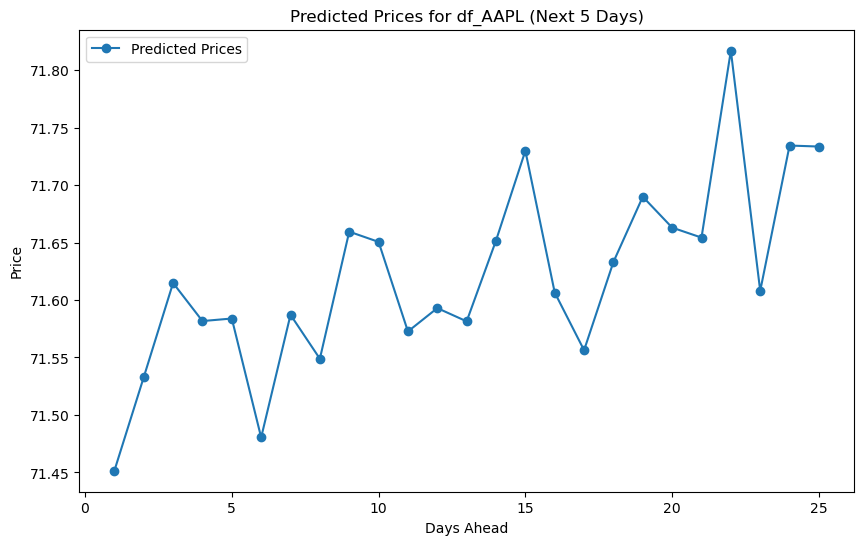

In [ ]:
# Visualize predictions for a specific company
company = 'df_AAPL'  # Example company
if company in predictions:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(predictions[company]) + 1), predictions[company], marker='o', label='Predicted Prices')
    plt.title(f"Predicted Prices for {company} (Next 5 Days)")
    plt.xlabel("Days Ahead")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
else:
    print(f"No predictions available for {company}.")


In [ ]:
all_dfs['df_AAPL'].tail()

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,AAPL_SMA_20,AAPL_RSI_14,AAPL_MACD,AAPL_MACD_Hist,AAPL_MACD_Signal,AAPL_BB_Lower,AAPL_BB_Middle,AAPL_BB_Upper,AAPL_BB_Bandwidth,AAPL_BB_Percentage,AAPL_MOM_10,AAPL_Close_Lag_1,AAPL_Close_Lag_2,AAPL_Close_Lag_3,AAPL_Close_Lag_4,AAPL_Close_Lag_5,AAPL_target_1,AAPL_target_2,AAPL_target_3,AAPL_target_4,AAPL_target_5,Effective Federal Funds Rate,10-Year Treasury Rate,Consumer Price Index,Producer Price Index,Unemployment Rate,Nonfarm Payroll Employment,Real GDP,Housing Starts,Industrial Production Index,M2 Money Stock,Crude Oil Prices,Retail Sales,Total Business Inventories
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-13,224.009995,226.649994,222.759995,225.119995,225.119995,48566200,228.720999,45.898620,-1.099138,-0.578193,-0.520945,219.405479,228.720999,238.036519,8.145750,0.306720,-4.980011,224.229996,224.229996,226.960007,227.479996,222.720001,228.220001,225.000000,228.020004,228.279999,229.000000,4.83,3.74,315.454,253.452,4.1,159005.0,23221.394667,1311.0,102.2805,21311.2,70.41,621590.0,2.558768e+06
2024-11-14,225.020004,228.869995,225.000000,228.220001,228.220001,44923900,228.524500,51.863176,-0.845442,-0.259597,-0.585845,219.341740,228.524500,237.707259,8.036564,0.483420,2.309998,225.119995,224.229996,224.229996,226.960007,227.479996,225.000000,228.020004,228.279999,229.000000,228.520004,4.83,3.74,315.454,253.452,4.1,159005.0,23221.394667,1311.0,102.2805,21311.2,70.41,621590.0,2.558768e+06
2024-11-15,226.399994,226.919998,224.270004,225.000000,225.000000,47923700,228.024500,46.169379,-0.893908,-0.246451,-0.647457,219.225576,228.024500,236.823423,7.717525,0.328132,2.089996,228.220001,225.119995,224.229996,224.229996,226.960007,228.020004,228.279999,229.000000,228.520004,229.869995,4.83,3.74,315.454,253.452,4.1,159005.0,23221.394667,1311.0,102.2805,21311.2,70.41,621590.0,2.558768e+06
2024-11-18,225.250000,229.740005,225.169998,228.020004,228.020004,44686000,227.601500,51.542650,-0.680781,-0.026659,-0.654122,219.701736,227.601500,235.501264,6.941750,0.526488,6.010010,225.000000,228.220001,225.119995,224.229996,224.229996,228.279999,229.000000,228.520004,229.869995,232.869995,4.83,3.74,315.454,253.452,4.1,159005.0,23221.394667,1311.0,102.2805,21311.2,70.41,621590.0,2.558768e+06
2024-11-19,226.979996,230.160004,226.660004,228.279999,228.279999,36211800,227.222500,51.986984,-0.485303,0.135055,-0.620358,220.273888,227.222500,234.171112,6.116130,0.576094,4.830002,228.020004,225.000000,228.220001,225.119995,224.229996,229.000000,228.520004,229.869995,232.869995,235.059998,4.83,3.74,315.454,253.452,4.1,159005.0,23221.394667,1311.0,102.2805,21311.2,70.41,621590.0,2.558768e+06


### For Individual companies

In [50]:
all_dfs.keys()

dict_keys(['df_AAPL', 'df_NVDA', 'df_MSFT', 'df_GOOG', 'df_GOOGL', 'df_AMZN', 'df_META', 'df_AVGO', 'df_LLY', 'df_TSLA', 'df_WMT', 'df_JPM', 'df_V', 'df_XOM', 'df_UNH', 'df_ORCL', 'df_MA', 'df_HD', 'df_PG', 'df_COST', 'df_JNJ', 'df_NFLX', 'df_ABBV', 'df_BAC', 'df_KO', 'df_CRM', 'df_CVX', 'df_MRK', 'df_TMUS', 'df_AMD', 'df_PEP', 'df_ACN', 'df_LIN', 'df_TMO', 'df_MCD', 'df_CSCO', 'df_ADBE', 'df_WFC', 'df_IBM', 'df_GE', 'df_ABT', 'df_DHR', 'df_AXP', 'df_MS', 'df_CAT', 'df_NOW', 'df_QCOM', 'df_PM', 'df_ISRG', 'df_VZ'])

In [51]:
#all_dfs['df_AAPL'].columns

In [52]:
#for comp,df in all_dfs.items():
#    print("Processing", comp)


In [71]:
#import pickle

# Writing to a Pickle file
#with open('all_dfs.pkl', 'wb') as file:
#    pickle.dump(all_dfs, file)

In [72]:
# Reading from a Pickle file
#with open('all_dfs.pkl', 'rb') as file:
#    loaded_data = pickle.load(file)

In [73]:
#type(loaded_data)

dict

In [53]:
df = all_dfs["df_AAPL"]

In [74]:
df.tail()

,VZ_Open,VZ_High,VZ_Low,VZ_Close,VZ_Adj Close,VZ_Volume,VZ_SMA_20,VZ_RSI_14,VZ_MACD,VZ_MACD_Hist,VZ_MACD_Signal,VZ_BB_Lower,VZ_BB_Middle,VZ_BB_Upper,VZ_BB_Bandwidth,VZ_BB_Percentage,VZ_MOM_10,VZ_Close_Lag_1,VZ_Close_Lag_2,VZ_Close_Lag_3,VZ_Close_Lag_4,VZ_Close_Lag_5,VZ_target_1,VZ_target_2,VZ_target_3,VZ_target_4,VZ_target_5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-13,40.400002,41.400002,40.310001,41.139999,41.139999,19953500,41.6685,43.280060,-0.693609,-0.049700,-0.643909,39.512956,41.6685,43.824045,10.346159,0.377409,-0.139999,40.400002,40.439999,40.480000,40.570000,41.160000,40.869999,41.650002,42.250000,41.930000,42.220001
2024-11-14,41.139999,41.259998,40.860001,40.869999,40.869999,13636600,41.5195,41.174577,-0.662398,-0.014791,-0.647607,39.587325,41.5195,43.451676,9.307316,0.331925,-1.260002,41.139999,40.400002,40.439999,40.480000,40.570000,41.650002,42.250000,41.930000,42.220001,42.500000
2024-11-15,40.799999,41.770000,40.799999,41.650002,41.650002,21482500,41.4025,48.907401,-0.568174,0.063546,-0.631720,39.833654,41.4025,42.971346,7.578507,0.578880,0.290001,40.869999,41.139999,40.400002,40.439999,40.480000,42.250000,41.930000,42.220001,42.500000,43.150002
2024-11-18,41.669998,42.580002,41.669998,42.250000,42.250000,17409000,41.3300,53.924804,-0.440013,0.153365,-0.593379,40.093796,41.3300,42.566205,5.982117,0.872107,1.189999,41.650002,40.869999,41.139999,40.400002,40.439999,41.930000,42.220001,42.500000,43.150002,43.980000
2024-11-19,42.209999,42.230000,41.799999,41.930000,41.930000,10520600,41.3515,51.045656,-0.360115,0.186611,-0.546726,40.089529,41.3515,42.613472,6.103632,0.729205,0.670002,42.250000,41.650002,40.869999,41.139999,40.400002,42.220001,42.500000,43.150002,43.980000,44.369999


In [55]:
df1 = df["AAPL_Close"]

In [56]:
df1

Date
2003-02-20      0.263750
2003-02-21      0.267857
2003-02-24      0.263214
2003-02-25      0.268214
2003-02-26      0.258929
                 ...    
2024-11-13    225.119995
2024-11-14    228.220001
2024-11-15    225.000000
2024-11-18    228.020004
2024-11-19    228.279999
Name: AAPL_Close, Length: 5476, dtype: float64

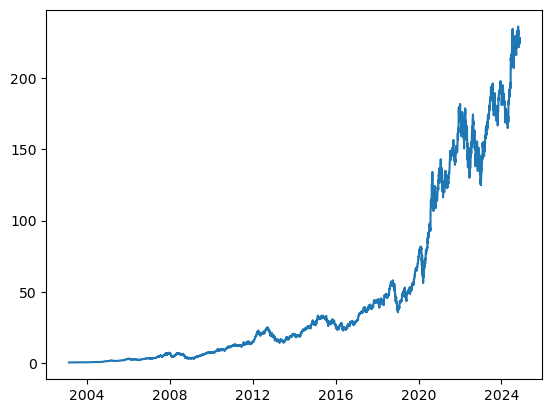

In [57]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [58]:
df1

Date
2003-02-20      0.263750
2003-02-21      0.267857
2003-02-24      0.263214
2003-02-25      0.268214
2003-02-26      0.258929
                 ...    
2024-11-13    225.119995
2024-11-14    228.220001
2024-11-15    225.000000
2024-11-18    228.020004
2024-11-19    228.279999
Name: AAPL_Close, Length: 5476, dtype: float64

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [63]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.75)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [64]:
training_size,test_size

(4107, 1369)

In [65]:
train_data

array([[1.24717573e-04],
       [1.42102009e-04],
       [1.22448771e-04],
       ...,
       [2.05160184e-01],
       [2.04504093e-01],
       [2.04461755e-01]])

In [66]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [67]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [180]:
print(X_train.shape)
print(y_train.shape)

(4006, 100)
(4006,)


In [68]:
print(X_test.shape)
print(ytest.shape)

(1268, 100)
(1268,)


In [69]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [71]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


2024-11-30 18:32:06.104008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 18:32:06.104487: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 18:32:06.104878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [74]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


2024-11-30 18:32:11.371167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-30 18:32:11.618788: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7a18f0003d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-30 18:32:11.618842: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-30 18:32:11.618854: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-30 18:32:11.623550: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 18:32:11.690183: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 [==============================] - 3s 19ms/step - loss: 7.1638e-04 - val_loss: 0.0013
Epoch 2/100
63/63 [==============================] - 1s 11ms/step - loss: 2.5074e-05 - val_loss: 0.0030
Epoch 3/100
63/63 [==============================] - 1s 11ms/step - loss: 2.2197e-05 - val_loss: 0.0061
Epoch 4/100
63/63 [==============================] - 1s 9ms/step - loss: 2.1545e-05 - val_loss: 0.0055
Epoch 5/100
63/63 [==============================] - 1s 10ms/step - loss: 1.8299e-05 - val_loss: 0.0071
Epoch 6/100
63/63 [==============================] - 1s 11ms/step - loss: 1.9937e-05 - val_loss: 0.0073
Epoch 7/100
63/63 [==============================] - 1s 12ms/step - loss: 1.8318e-05 - val_loss: 0.0047
Epoch 8/100
63/63 [==============================] - 1s 13ms/step - loss: 1.7165e-05 - val_loss: 0.0030
Epoch 9/100
63/63 [==============================] - 1s 14ms/step - loss: 1.7314e-05 - val_loss: 0.0030
Epoch 10/100
63/63 [==============================] - 1s 11ms/step - loss: 1.

In [75]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

40/40 [==============================] - 0s 4ms/step


In [76]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [77]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.0016562849696855507

In [78]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.04066852706334099

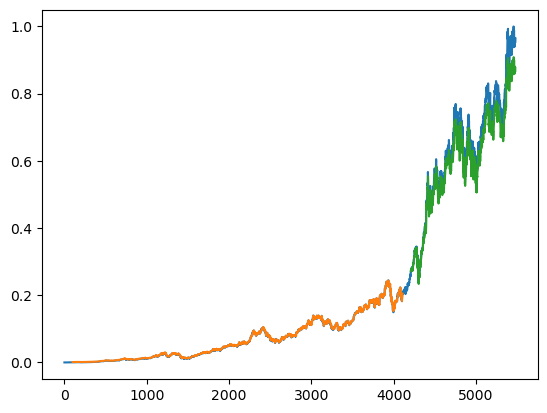

In [79]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [82]:
seq_len = len(test_data)
seq_len

1369

In [84]:
x_input=test_data[seq_len-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [85]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [86]:
temp_input

[0.9164852739552122,
 0.9313850335167783,
 0.9368031161594133,
 0.9570785882158713,
 0.9633432987496878,
 0.9669835144917533,
 0.9851849161452801,
 0.9622850784743507,
 0.9748566759238073,
 0.9911955995585583,
 0.9929734664591278,
 0.967830142382935,
 0.9479355495356848,
 0.948485844747225,
 0.9470043751149368,
 0.951448848600441,
 0.9240621027076246,
 0.9196176292221205,
 0.9216070885068455,
 0.9227922900481319,
 0.9251626931307048,
 0.9390465379760368,
 0.923300215111929,
 0.9296495367639518,
 0.8848233414019442,
 0.8761882277855548,
 0.8871514389254138,
 0.9019241526323908,
 0.9143265278454348,
 0.9197869160471729,
 0.9356179146181268,
 0.9375226981960058,
 0.9502213415000514,
 0.9558510811154818,
 0.9551738046379924,
 0.9577981702524638,
 0.9573325507477698,
 0.9494170837566128,
 0.9591950287665456,
 0.9606341928397305,
 0.9642321676113328,
 0.9577135591342575,
 0.9716820150977958,
 0.968338067446732,
 0.9419672362701497,
 0.9338401123061972,
 0.9403164152241693,
 0.933713131040248

In [107]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

0 day output [[0.0012728]]
1 day output [[0.00131707]]
2 day output [[0.00169026]]
3 day output [[0.00231517]]
4 day output [[0.0031275]]
5 day output [[0.00407403]]
6 day output [[0.00511097]]
7 day output [[0.00620267]]
8 day output [[0.00732057]]
9 day output [[0.00844214]]
10 day output [[0.00955003]]
11 day output [[0.01063123]]
12 day output [[0.01167637]]
13 day output [[0.01267907]]
14 day output [[0.01363538]]
15 day output [[0.01454333]]
16 day output [[0.01540246]]
17 day output [[0.01621354]]
18 day output [[0.01697824]]
19 day output [[0.01769889]]
20 day output [[0.01837827]]
21 day output [[0.01901945]]
22 day output [[0.01962569]]
23 day output [[0.02020026]]
24 day output [[0.02074639]]
25 day output [[0.02126721]]
26 day output [[0.02176571]]
27 day output [[0.02224467]]
28 day output [[0.02270667]]
29 day output [[0.02315405]]


In [108]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [109]:
total_days = len(df1)

In [110]:
df3 = df1.tolist()
df3.extend(lst_output)

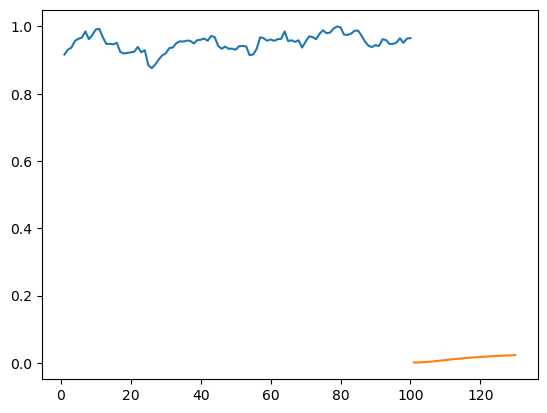

In [111]:
plt.plot(day_new,scaler.inverse_transform(df1[total_days-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

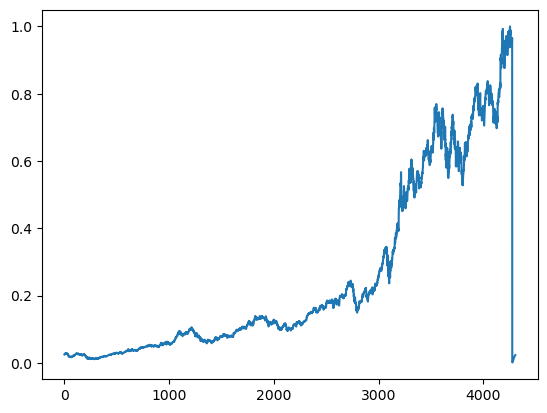

In [112]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [113]:
df3=scaler.inverse_transform(df3).tolist()

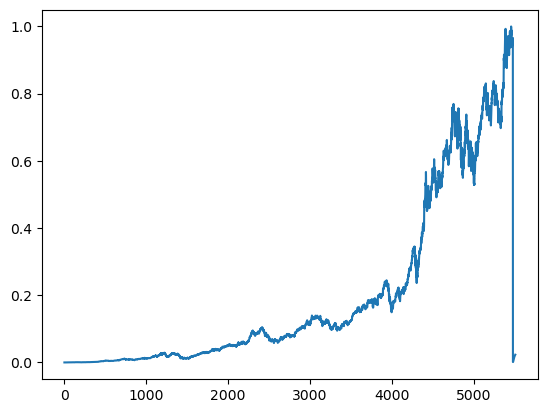

In [114]:
plt.plot(df3)